In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Cinema_Audience_Forecasting_challenge/movie_theater_id_relation/movie_theater_id_relation.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/date_info/date_info.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/sample_submission/sample_submission.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_theaters/booknow_theaters.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_booking/cinePOS_booking.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_theaters/cinePOS_theaters.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_visits/booknow_visits.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_booking/booknow_booking.csv


# Cinema Audience Forecasting using Machine Learning  
### Kaggle Competition Project – MLP Level 1 Viva  
**Roll Number:** 23f2003068  
**Student Name:** Vikas Yadav  
**Program:** BS in Data Science and Applications – IIT Madras  
**Term:** September 2025  

---

## Problem Statement

The objective of this project is to predict the daily audience attendance for each cinema theater using historical data from two sources: BookNow (online bookings) and CinePOS (offline POS sales).  
The target variable is audience_count, and the task is a supervised time-series regression problem where audience demand depends on seasonality, theater location, booking behavior, and overall market trends.

Accurate forecasting of cinema audience helps in:
- Better show scheduling  
- Efficient staff and resource planning  
- Improved revenue estimation  

---

## Aim

The aim of this project is to build an accurate machine learning model that can predict the daily audience count for each (theater, date) pair in the test dataset.

This is achieved through:
- Exploratory Data Analysis
- Feature engineering from time, location, and booking data
- Training and comparing multiple machine learning models
- Building a hybrid ensemble model
- Generating the final Kaggle submission file (submission.csv)


## 1. Environment Setup & Libraries

In [2]:
# ===================================================================
# 1. ENVIRONMENT SETUP & LIBRARY IMPORTS
# ===================================================================

import os
import gc
import warnings

import numpy as np                     
import pandas as pd                    
import matplotlib.pyplot as plt      
import seaborn as sns                   

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.cluster import KMeans
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor

import lightgbm as lgb                  
from xgboost import XGBRegressor      

# Suppress warnings for cleaner notebook output
warnings.filterwarnings("ignore")

print("Libraries imported successfully.")

Libraries imported successfully.


## 2. Data Loading

In [3]:
# ===================================================================
#  DATA LOADING
# ===================================================================

# BookNow platform files
booknow_booking = pd.read_csv(
    "/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_booking/booknow_booking.csv",
    parse_dates=["show_datetime", "booking_datetime"]
)

booknow_theaters = pd.read_csv(
    "/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_theaters/booknow_theaters.csv"
)

booknow_visits = pd.read_csv(
    "/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_visits/booknow_visits.csv",
    parse_dates=["show_date"]
)

# CinePOS platform files
cinepos_booking = pd.read_csv(
    "/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_booking/cinePOS_booking.csv",
    parse_dates=["show_datetime", "booking_datetime"]
)

cinepos_theaters = pd.read_csv(
    "/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_theaters/cinePOS_theaters.csv"
)

# Shared info & submission template
date_info = pd.read_csv(
    "/kaggle/input/Cinema_Audience_Forecasting_challenge/date_info/date_info.csv",
    parse_dates=["show_date"]
)

id_relation = pd.read_csv(
    "/kaggle/input/Cinema_Audience_Forecasting_challenge/movie_theater_id_relation/movie_theater_id_relation.csv"
)

sample_submission = pd.read_csv(
    "/kaggle/input/Cinema_Audience_Forecasting_challenge/sample_submission/sample_submission.csv"
)

print("All data files loaded successfully.")

All data files loaded successfully.


## 3️. Exploratory Data Analysis (EDA)

In [4]:
# ===================================================================
# DATASET SHAPES & BASIC STRUCTURE
# ===================================================================

def summarize_df(df, name):
    """Return a small summary for one DataFrame."""
    return {
        "table": name,
        "rows": df.shape[0],
        "columns": df.shape[1],
    }

summary_list = [
    summarize_df(booknow_booking, "booknow_booking"),
    summarize_df(booknow_theaters, "booknow_theaters"),
    summarize_df(booknow_visits, "booknow_visits"),
    summarize_df(cinepos_booking, "cinePOS_booking"),
    summarize_df(cinepos_theaters, "cinePOS_theaters"),
    summarize_df(date_info, "date_info"),
    summarize_df(id_relation, "movie_theater_id_relation"),
    summarize_df(sample_submission, "sample_submission"),
]

summary_df = pd.DataFrame(summary_list)
display(summary_df)

,table,rows,columns
0,booknow_booking,68336,4
1,booknow_theaters,829,5
2,booknow_visits,214046,3
3,cinePOS_booking,1641966,4
4,cinePOS_theaters,4690,5
5,date_info,547,2
6,movie_theater_id_relation,150,2
7,sample_submission,38062,2


### Preview Of Dataset

In [5]:
booknow_booking.head()

,book_theater_id,show_datetime,booking_datetime,tickets_booked
0,book_00244,2023-01-01 19:00:00,2023-01-01 16:00:00,1
1,book_00740,2023-01-01 19:00:00,2023-01-01 19:00:00,3
2,book_00740,2023-01-01 19:00:00,2023-01-01 19:00:00,6
3,book_00244,2023-01-01 20:00:00,2023-01-01 16:00:00,2
4,book_00151,2023-01-01 20:00:00,2023-01-01 01:00:00,5


In [6]:
booknow_theaters.head()

,book_theater_id,theater_type,theater_area,latitude,longitude
0,book_00093,Drama,Area_001,22.619233,78.113017
1,book_00078,Drama,Area_001,22.619233,78.113017
2,book_00291,Drama,Area_001,22.619233,78.113017
3,book_00258,Drama,Area_001,22.619233,78.113017
4,book_00212,Drama,Area_002,23.004410,79.934515


In [7]:
booknow_visits.head()

,book_theater_id,show_date,audience_count
0,book_00001,2023-01-13,50
1,book_00001,2023-01-14,64
2,book_00001,2023-01-15,58
3,book_00001,2023-01-16,44
4,book_00001,2023-01-18,12


In [8]:
cinepos_booking.head()

,cine_theater_id,show_datetime,booking_datetime,tickets_sold
0,cinePOS_00001,2023-01-01 11:00:00,2023-01-01 09:00:00,1
1,cinePOS_00002,2023-01-01 13:00:00,2023-01-01 06:00:00,3
2,cinePOS_00003,2023-01-01 16:00:00,2023-01-01 14:00:00,2
3,cinePOS_00004,2023-01-01 17:00:00,2023-01-01 11:00:00,5
4,cinePOS_00005,2023-01-01 17:00:00,2023-01-01 03:00:00,13


In [9]:
cinepos_theaters.head()

,cine_theater_id,theater_type,theater_area,latitude,longitude
0,cinePOS_05466,Other,Area_104,22.619233,78.113017
1,cinePOS_08708,Other,Area_104,22.619233,78.113017
2,cinePOS_00753,Other,Area_104,22.619233,78.113017
3,cinePOS_05776,Other,Area_104,22.619233,78.113017
4,cinePOS_07536,Other,Area_104,23.004410,79.934515


In [10]:
date_info.head()

,show_date,day_of_week
0,2023-01-01,Sunday
1,2023-01-02,Monday
2,2023-01-03,Tuesday
3,2023-01-04,Wednesday
4,2023-01-05,Thursday


In [11]:
id_relation.head()

,book_theater_id,cine_theater_id
0,book_00509,cinePOS_01261
1,book_00063,cinePOS_02467
2,book_00054,cinePOS_08923
3,book_00094,cinePOS_02479
4,book_00052,cinePOS_06750


### 3.1 Observations on Dataset Structure

From the dataset summary table, we observe the following:

- cinePOS_booking is the largest table with 1,641,966 rows and contains offline ticket sales transactions.
- booknow_booking has 68,336 rows and contains online ticket booking transactions.
- booknow_visits has 214,046 rows and stores the final daily audience count for each (book_theater_id, show_date) pair. This is the target table for prediction.
- booknow_theaters (829 rows) and cinePOS_theaters (4,690 rows) provide theater-level information such as area, type, and location.
- movie_theater_id_relation (150 rows) is used to map CinePOS theater IDs to BookNow theater IDs so that both platforms can be combined.
- date_info (547 rows) provides calendar information such as the day of the week.
- sample_submission (38,062 rows) shows the required output format for Kaggle submissions.

Key conclusions:

- This is a time-series regression problem at the level of (theater, date).
- Multiple tables need to be merged using theater IDs and dates to create the final modeling dataset.
- Both online and offline booking data are important for accurate audience prediction.

Date range in booknow_visits (target table):
  Min date: 2023-01-01 00:00:00
  Max date: 2024-02-28 00:00:00

 Date range in date_info:
  Min date: 2023-01-01 00:00:00
  Max date: 2024-06-30 00:00:00

 audience_count summary statistics:


count    214046.000000
mean         41.616568
std          32.834918
min           2.000000
25%          18.000000
50%          34.000000
75%          58.000000
max        1350.000000
Name: audience_count, dtype: float64

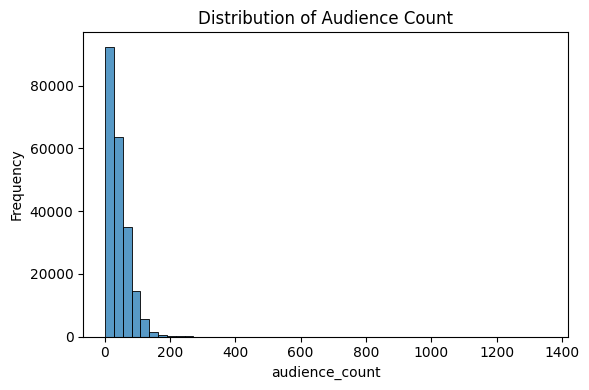

In [12]:
# ===================================================================
# 3.2 BASIC TEMPORAL & TARGET CHECKS
# ===================================================================

print("Date range in booknow_visits (target table):")
print("  Min date:", booknow_visits["show_date"].min())
print("  Max date:", booknow_visits["show_date"].max())

print("\n Date range in date_info:")
print("  Min date:", date_info["show_date"].min())
print("  Max date:", date_info["show_date"].max())

# Basic statistics of the target variable
print("\n audience_count summary statistics:")
display(booknow_visits["audience_count"].describe())

plt.figure(figsize=(6, 4))
sns.histplot(booknow_visits["audience_count"], bins=50, kde=False)
plt.title("Distribution of Audience Count")
plt.xlabel("audience_count")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

### 3.2 Target Variable & Temporal Coverage – Observations

From the output:

Date range:
- booknow_visits covers data from 1 January 2023 to 28 February 2024.
- date_info covers a wider range from 1 January 2023 to 30 June 2024.

This provides more than one year of continuous daily data, which is sufficient to learn weekly and seasonal patterns and also supports future date forecasting.

Target variable: audience_count

Summary statistics:
- Total records: 214,046
- Mean audience: 41.6
- Median audience: 34
- Standard deviation: 32.83
- Minimum: 2
- Maximum: 1350

Distribution shape from the histogram:
- The distribution of audience_count is strongly right-skewed.
- Most days have low to moderate attendance, mainly between 10 and 60.
- A small number of days have very high attendance, reaching above 500 and up to 1350.
- These extreme values likely correspond to weekends, holidays, or blockbuster movie releases.

Key implications for modeling:
- Large errors on high-demand days can strongly affect RMSE.
- The skewed distribution supports the use of tree-based and ensemble models.
- Lag features and rolling averages are useful for handling demand variability.

Overall, the target variable is clean, realistic, and suitable for time-series regression with seasonality.


In [13]:
# ===================================================================
# 3.3 MISSING VALUE ANALYSIS
# ===================================================================

def missing_value_summary(df, name):
    """Return count and percentage of missing values for a dataframe."""
    missing_count = df.isnull().sum()
    missing_percent = (missing_count / len(df)) * 100
    summary = pd.DataFrame({
        "column": missing_count.index,
        "missing_count": missing_count.values,
        "missing_percent": missing_percent.values
    })
    summary = summary[summary["missing_count"] > 0]
    summary = summary.sort_values(by="missing_percent", ascending=False)
    
    print(f"\n Missing Value Summary: {name}")
    if summary.empty:
        print("No missing values found.")
    else:
        display(summary)

# Check missing values in all major tables
missing_value_summary(booknow_visits, "booknow_visits")
missing_value_summary(booknow_booking, "booknow_booking")
missing_value_summary(cinepos_booking, "cinePOS_booking")
missing_value_summary(booknow_theaters, "booknow_theaters")
missing_value_summary(cinepos_theaters, "cinePOS_theaters")


 Missing Value Summary: booknow_visits
No missing values found.

 Missing Value Summary: booknow_booking
No missing values found.

 Missing Value Summary: cinePOS_booking
No missing values found.

 Missing Value Summary: booknow_theaters


,column,missing_count,missing_percent
0,book_theater_id,515,62.12304



 Missing Value Summary: cinePOS_theaters


,column,missing_count,missing_percent
3,latitude,3861,82.324094
4,longitude,3861,82.324094


### 3.3 Missing Value Analysis – Observations

From the missing value inspection:

- booknow_visits  
  No missing values found.  
  This is the target table and is clean for model training.

- booknow_booking  
  No missing values found.  
  All online booking records are complete.

- cinePOS_booking  
  No missing values found.  
  Offline POS transaction data is also complete.

- booknow_theaters  
  One column has missing values:
  - book_theater_id has 515 missing values (about 62.1 percent).

- cinePOS_theaters  
  Two columns have large missing values:
  - latitude has 3861 missing values (about 82.3 percent).
  - longitude has 3861 missing values (about 82.3 percent).

Key conclusions:

- All main transactional and target tables have no missing values, which is good for model stability.
- Missing values appear only in theater metadata, mainly in location-related columns.
- These missing values will be handled during preprocessing and feature engineering.

day_of_week
Tuesday      35.039099
Wednesday    35.220707
Friday       37.626460
Thursday     37.992760
Saturday     45.244812
Monday       47.623494
Sunday       51.713413
Name: audience_count, dtype: float64

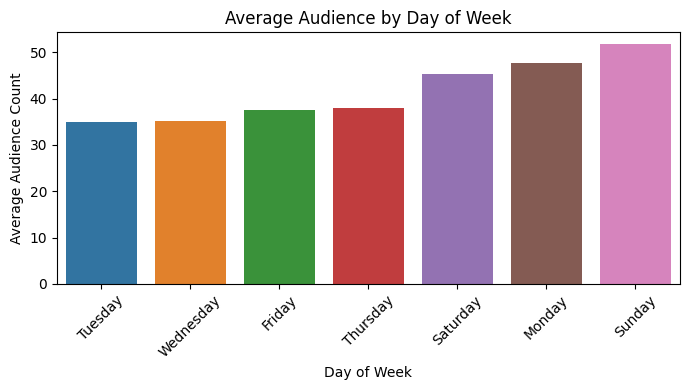

is_weekend
0    38.510347
1    48.440661
Name: audience_count, dtype: float64

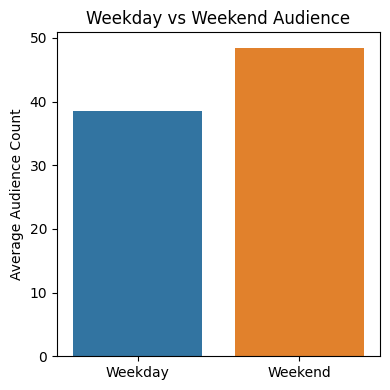

In [14]:
# ===================================================================
# 3.4 DAY-OF-WEEK & WEEKEND EFFECT ON AUDIENCE
# ===================================================================

# Merge day-of-week information into target table
visits_with_day = booknow_visits.merge(
    date_info, on="show_date", how="left"
)

# Audience by day of week
dow_trend = visits_with_day.groupby("day_of_week")["audience_count"].mean().sort_values()

display(dow_trend)

plt.figure(figsize=(7, 4))
sns.barplot(x=dow_trend.index, y=dow_trend.values)
plt.title("Average Audience by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Average Audience Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Weekend vs Weekday
visits_with_day["is_weekend"] = visits_with_day["day_of_week"].isin(["Saturday", "Sunday"]).astype(int)

weekend_trend = visits_with_day.groupby("is_weekend")["audience_count"].mean()

display(weekend_trend)

plt.figure(figsize=(4, 4))
sns.barplot(x=["Weekday", "Weekend"], y=weekend_trend.values)
plt.title("Weekday vs Weekend Audience")
plt.ylabel("Average Audience Count")
plt.tight_layout()
plt.show()

### 3.4 Day-of-Week & Weekend Effect – Observations

Average audience by day of week:

Tuesday: 35.04  
Wednesday: 35.22  
Friday: 37.63  
Thursday: 37.99  
Saturday: 45.24  
Monday: 47.62  
Sunday: 51.71  

Observations from day-wise averages:

- Sunday has the highest average audience (about 51.7).
- Monday and Saturday also show high attendance.
- Tuesday and Wednesday have the lowest audience levels.
- This shows a clear weekly demand pattern.

Weekday vs Weekend averages:

Weekday average audience: 38.51  
Weekend average audience: 48.44  

Observations:

- Weekend audience is about 10 people higher than weekday audience.
- This confirms a strong weekend effect on cinema attendance.

Modeling implications:

- Audience demand strongly depends on day_of_week and is_weekend.
- These features should be included in the model.
- Weekly rolling statistics and cyclical encodings are also useful for capturing this pattern.


month
1     39.953516
2     40.955389
3     45.733752
4     45.066634
5     44.018625
6     42.639020
7     42.535306
8     39.496977
9     39.816890
10    40.639430
11    39.503250
12    46.257681
Name: audience_count, dtype: float64

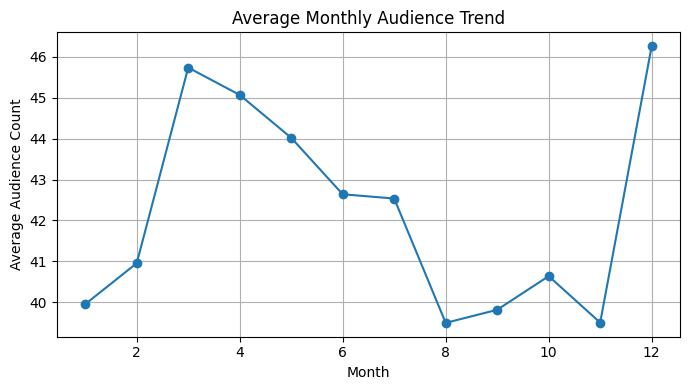

In [15]:
# ===================================================================
# 3.5 MONTHLY SEASONALITY TREND
# ===================================================================

monthly_trend = visits_with_day.copy()
monthly_trend["month"] = monthly_trend["show_date"].dt.month

monthly_avg = monthly_trend.groupby("month")["audience_count"].mean()

display(monthly_avg)

plt.figure(figsize=(7, 4))
plt.plot(monthly_avg.index, monthly_avg.values, marker='o')
plt.title("Average Monthly Audience Trend")
plt.xlabel("Month")
plt.ylabel("Average Audience Count")
plt.grid(True)
plt.tight_layout()
plt.show()


### 3.5 Monthly Seasonality – Observations

Average monthly audience values:

January: 39.95  
February: 40.95  
March: 45.73  
April: 45.07  
May: 44.02  
June: 42.64  
July: 42.54  
August: 39.50  
September: 39.82  
October: 40.64  
November: 39.50  
December: 46.26  

Observations:

- March, April, May, and December show the highest average audience.
- December has the maximum average audience.
- August, September, and November show relatively lower demand.
- This shows a clear yearly seasonal pattern in cinema attendance.

Modeling implications:

- Monthly and quarterly features are important.
- Cyclical seasonal features such as sine and cosine encoding should be used.
- These features help capture yearly demand fluctuations in the model.


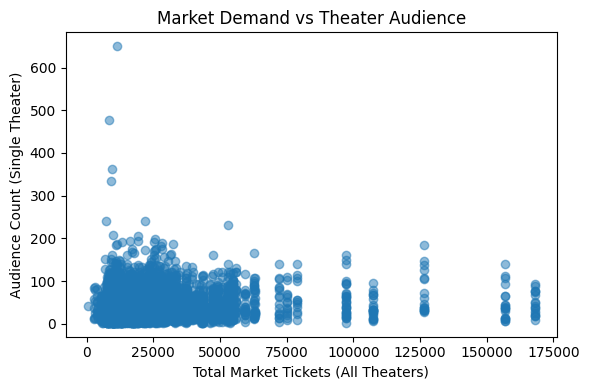

In [16]:
# ===================================================================
# 3.6 MARKET-LEVEL DEMAND VS THEATER AUDIENCE
# ===================================================================

# 1) Build daily total tickets for Online (BookNow)
bn_daily = booknow_booking.copy()
bn_daily["show_date"] = bn_daily["show_datetime"].dt.date
bn_daily = (
    bn_daily.groupby("show_date")["tickets_booked"]
    .sum()
    .reset_index(name="online_tickets")
)

# 2) Build daily total tickets for Offline (CinePOS)
cp_daily = cinepos_booking.copy()
cp_daily["show_date"] = cp_daily["show_datetime"].dt.date
cp_daily = (
    cp_daily.groupby("show_date")["tickets_sold"]
    .sum()
    .reset_index(name="pos_tickets")
)

# 3) Combine into daily market demand
market_daily = bn_daily.merge(cp_daily, on="show_date", how="outer")
market_daily["online_tickets"].fillna(0, inplace=True)
market_daily["pos_tickets"].fillna(0, inplace=True)
market_daily["total_market_tickets"] = (
    market_daily["online_tickets"] + market_daily["pos_tickets"]
)

# Convert show_date back to datetime to match booknow_visits
market_daily["show_date"] = pd.to_datetime(market_daily["show_date"])

# 4) Merge with target table
market_merge = booknow_visits.merge(market_daily, on="show_date", how="left")

# Sample for cleaner plotting
sample_size = min(5000, len(market_merge))
sample_df = market_merge.sample(sample_size, random_state=42)

# 5) Scatter plot: total market tickets vs audience_count
plt.figure(figsize=(6, 4))
plt.scatter(sample_df["total_market_tickets"], sample_df["audience_count"], alpha=0.5)
plt.xlabel("Total Market Tickets (All Theaters)")
plt.ylabel("Audience Count (Single Theater)")
plt.title("Market Demand vs Theater Audience")
plt.tight_layout()
plt.show()



### 3.6 Market Demand vs Individual Theater Audience – Observations

From the scatter plot of total market tickets versus individual theater audience:

- There is a positive relationship between overall market demand and single-theater audience.
- On days when total market ticket sales are high, most theaters also show higher audience.
- Even when market demand varies widely, individual theaters generally follow the same upward trend.

Key conclusions:

- Cinema attendance is influenced by both theater-level factors and overall market demand.
- Daily total market ticket features are useful global indicators.
- Rolling market demand features can help capture short-term demand trends.


online_tickets      713.306604
pos_tickets       19313.799528
dtype: float64

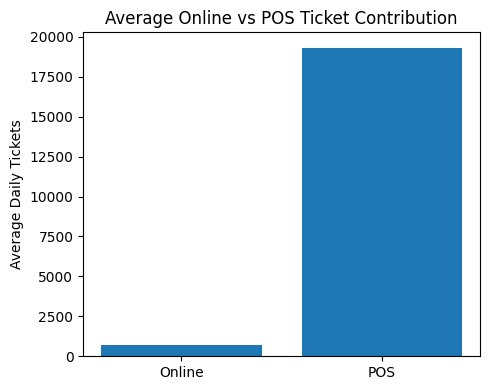

In [17]:
# ===================================================================
# 3.7 ONLINE VS OFFLINE (POS) BOOKING CONTRIBUTION
# ===================================================================

# 1) Daily Online Tickets (BookNow)
bn_daily = booknow_booking.copy()
bn_daily["show_date"] = bn_daily["show_datetime"].dt.date
bn_daily = (
    bn_daily.groupby("show_date")["tickets_booked"]
    .sum()
    .reset_index(name="online_tickets")
)

# 2) Daily Offline Tickets (CinePOS)
cp_daily = cinepos_booking.copy()
cp_daily["show_date"] = cp_daily["show_datetime"].dt.date
cp_daily = (
    cp_daily.groupby("show_date")["tickets_sold"]
    .sum()
    .reset_index(name="pos_tickets")
)

# 3) Merge Online + Offline
booking_compare = bn_daily.merge(cp_daily, on="show_date", how="outer")
booking_compare["online_tickets"].fillna(0, inplace=True)
booking_compare["pos_tickets"].fillna(0, inplace=True)

# 4) Compute Mean Contribution
booking_compare_mean = booking_compare[["online_tickets", "pos_tickets"]].mean()
display(booking_compare_mean)

# 5) Bar Plot
plt.figure(figsize=(5, 4))
plt.bar(["Online", "POS"], booking_compare_mean.values)
plt.ylabel("Average Daily Tickets")
plt.title("Average Online vs POS Ticket Contribution")
plt.tight_layout()
plt.show()


### 3.7 Online vs Offline Booking Contribution – Observations

Average daily ticket contribution:

Online (BookNow): about 713 tickets per day  
Offline (CinePOS): about 19,314 tickets per day  

Observations:

- Offline (POS) bookings dominate the total ticket volume by a very large margin.
- Online bookings form a much smaller share of total tickets.
- Even though smaller in volume, online bookings provide early signals of demand.

Modeling implications:

- Online and offline bookings should be treated as separate features.
- Features such as tickets_online, tickets_pos, and online_ratio are important.
- Lead-time features from both platforms help capture booking behavior.


theater_area
Area_042    90.523962
Area_032    79.400000
Area_030    76.159787
Area_066    74.706468
Area_085    74.545455
Area_089    71.400000
Area_075    62.426859
Area_007    62.268041
Area_033    61.609240
Area_081    59.109551
Name: audience_count, dtype: float64

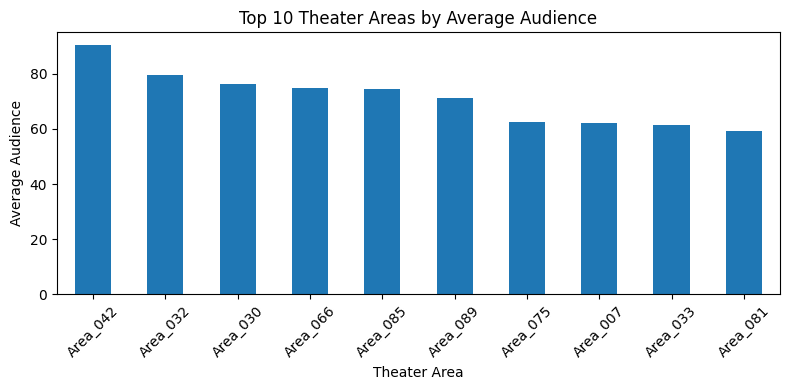

In [18]:
# ===================================================================
# 3.8 THEATER AREA VS AUDIENCE DISTRIBUTION
# ===================================================================

# Merge target table with theater metadata to get area info
visits_with_area = booknow_visits.merge(
    booknow_theaters[["book_theater_id", "theater_area"]],
    on="book_theater_id",
    how="left"
)

# Compute average audience per theater_area
area_avg = (
    visits_with_area
    .groupby("theater_area")["audience_count"]
    .mean()
    .sort_values(ascending=False)
)

display(area_avg.head(10))

plt.figure(figsize=(8, 4))
area_avg.head(10).plot(kind="bar")
plt.title("Top 10 Theater Areas by Average Audience")
plt.xlabel("Theater Area")
plt.ylabel("Average Audience")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 3.8 Theater Area Demand – Observations

Top 10 theater areas by average audience:

Area_042: 90.52  
Area_032: 79.40  
Area_030: 76.16  
Area_066: 74.71  
Area_085: 74.55  
Area_089: 71.40  
Area_075: 62.43  
Area_007: 62.27  
Area_033: 61.61  
Area_081: 59.11  

Observations:

- There is large variation in audience across different theater areas.
- Some areas such as Area_042 and Area_032 consistently have very high audience.
- Other areas show moderate but stable demand.

This likely reflects differences in:
- Population density
- Urban and semi-urban locations
- Local entertainment preferences

Modeling implications:

- Theater area should be used as a categorical feature.
- Spatial or geo-clustering features can help capture location-based demand.


## 4 Feature Engineering & Data Preparation

The goal of this section is to convert the raw multi-table data into a single modeling table (df_main) that contains all useful features for prediction.

The following groups of features are created:

1. Theater-level information  
- Theater area  
- Theater type  
- Geographical clusters based on latitude and longitude  

2. Calendar and seasonality features  
- Month, quarter, day of year, week of year  
- Day of week, weekend flag, Friday indicator  
- Cyclical seasonal encoding using sine and cosine  

3. Booking behaviour from both platforms  
- Daily tickets sold online (BookNow) and offline (CinePOS)  
- Lead time between booking and show time  
- Number of shows per day  
- Fraction of evening shows  

4. Market-level demand features  
- Total tickets sold across all theaters per day  
- 7-day rolling average of total market demand  

5. Time-series history of each theater  
- Lag features of audience_count (1, 7, 14, 28 days)  
- Rolling means over 7 and 14 days  

6. Interaction features  
- Tickets multiplied by weekend flag  
- Lagged audience multiplied by tickets  

These features are based on the idea that audience demand depends on holidays, weekends, theater type, location, and booking patterns.

All transformations are deterministic and are applied only using past information, so no data leakage is introduced.


In [19]:
# ===================================================================
# 4. FEATURE ENGINEERING – BUILD TRAINING TABLE df_main
# ===================================================================

# -----------------------------
# 4.1 Geospatial clustering
# -----------------------------
all_theaters = pd.concat([
    # Rename booknow_theaters id to a common generic name
    booknow_theaters.rename(columns={"book_theater_id": "theater_id"}),

    # Map cinePOS theaters to book_theater_id using the relation table
    cinepos_theaters
        .merge(id_relation, on="cine_theater_id")
        .drop(columns=["cine_theater_id"])
        .rename(columns={"book_theater_id": "theater_id"})
], ignore_index=True).drop_duplicates(subset="theater_id")

# Impute missing latitude/longitude within each theater_area, then globally
all_theaters["latitude"] = all_theaters.groupby("theater_area")["latitude"].transform(
    lambda x: x.fillna(x.mean())
)
all_theaters["longitude"] = all_theaters.groupby("theater_area")["longitude"].transform(
    lambda x: x.fillna(x.mean())
)
all_theaters["latitude"].fillna(all_theaters["latitude"].mean(), inplace=True)
all_theaters["longitude"].fillna(all_theaters["longitude"].mean(), inplace=True)

# Cluster theaters into geo buckets
kmeans = KMeans(n_clusters=20, random_state=42, n_init="auto")
all_theaters["geo_cluster"] = kmeans.fit_predict(all_theaters[["latitude", "longitude"]])

theater_geo_features = (
    all_theaters[["theater_id", "latitude", "longitude", "geo_cluster"]]
    .rename(columns={"theater_id": "book_theater_id"})
)

print("Geospatial features created.")

Geospatial features created.


In [20]:
# ---------------------------------------------------------------------
# 4.2 Start from visits (target table) and add calendar + theater info
# ---------------------------------------------------------------------
df_main = booknow_visits.copy()  # daily audience per (book_theater_id, show_date)

# Add date_info (day_of_week etc.)
df_main = df_main.merge(date_info, on="show_date", how="left")

# Add theater metadata and geo cluster
df_main = df_main.merge(
    booknow_theaters.drop(columns=["latitude", "longitude"]),
    on="book_theater_id",
    how="left",
)
df_main = df_main.merge(theater_geo_features, on="book_theater_id", how="left")

# Handle missing theater metadata
df_main["theater_type"].fillna("Unknown", inplace=True)
df_main["theater_area"].fillna("Unknown", inplace=True)

# Calendar features
df_main["show_month"] = df_main["show_date"].dt.month
df_main["show_quarter"] = df_main["show_date"].dt.quarter
df_main["show_dayofyear"] = df_main["show_date"].dt.dayofyear
df_main["show_weekofyear"] = df_main["show_date"].dt.isocalendar().week.astype("int32")
df_main["show_dayofweek_num"] = df_main["show_date"].dt.dayofweek
df_main["is_weekend"] = (df_main["show_dayofweek_num"] >= 5).astype(int)
df_main["is_friday"] = (df_main["show_dayofweek_num"] == 4).astype(int)

# Seasonal (cyclical) encoding
df_main["season_sin"] = np.sin(2 * np.pi * df_main["show_dayofyear"] / 365)
df_main["season_cos"] = np.cos(2 * np.pi * df_main["show_dayofyear"] / 365)

print("4.2 Base table + calendar + theater info created.")

4.2 Base table + calendar + theater info created.


In [21]:
# -------------------------------------------------------------------------
# 4.3 Aggregate bookings: online (BookNow) & offline (CinePOS)
# -------------------------------------------------------------------------
def get_daily_agg(booking_df, id_col, tickets_col):
    """
    Aggregate show-level booking data to daily per-theater level.
    Creates:
      - tickets: total tickets
      - mean_lead: avg days between booking and show
      - num_shows: number of unique show times
      - frac_evening: share of evening shows (hour >= 17)
    """
    booking_df["show_date"] = pd.to_datetime(booking_df["show_datetime"].dt.date)
    booking_df["lead_days"] = (
        booking_df["show_datetime"] - booking_df["booking_datetime"]
    ).dt.total_seconds() / (24 * 3600)
    booking_df["show_hour"] = booking_df["show_datetime"].dt.hour

    agg_df = (
        booking_df.groupby(["show_date", id_col])
        .agg(
            tickets=(tickets_col, "sum"),
            mean_lead=("lead_days", "mean"),
            num_shows=("show_datetime", "nunique"),
            frac_evening=("show_hour", lambda x: (x >= 17).mean()),
        )
        .reset_index()
    )
    return agg_df

# Daily online bookings
daily_bn = get_daily_agg(booknow_booking, "book_theater_id", "tickets_booked")

# Daily POS bookings (cinePOS), then map IDs to book_theater_id
daily_cp = (
    get_daily_agg(cinepos_booking, "cine_theater_id", "tickets_sold")
    .merge(id_relation, on="cine_theater_id")
    .drop(columns=["cine_theater_id"])
)
print("4.3 Daily online and POS bookings aggregated.")

4.3 Daily online and POS bookings aggregated.


In [22]:
# -----------------------------------
# 4.4 Market-level demand time series
# -----------------------------------
market_trends = (
    pd.concat([daily_bn, daily_cp])
    .groupby("show_date")["tickets"]
    .sum()
    .reset_index(name="total_market_tickets")
)
market_trends["market_rolling_7d"] = market_trends["total_market_tickets"].rolling(
    7, min_periods=1
).mean()

# Merge market and per-theater booking stats into df_main
df_main = df_main.merge(market_trends, on="show_date", how="left")

df_main = df_main.merge(
    daily_bn.rename(
        columns={
            "tickets": "tickets_online",
            "mean_lead": "mean_lead_online",
            "num_shows": "num_shows_online",
            "frac_evening": "frac_evening_online",
        }
    ),
    on=["show_date", "book_theater_id"],
    how="left",
)

df_main = df_main.merge(
    daily_cp.rename(
        columns={
            "tickets": "tickets_pos",
            "mean_lead": "mean_lead_pos",
            "num_shows": "num_shows_pos",
            "frac_evening": "frac_evening_pos",
        }
    ),
    on=["show_date", "book_theater_id"],
    how="left",
)

# Fill NaNs in sparse booking columns
for col in [
    "tickets_online",
    "tickets_pos",
    "num_shows_online",
    "num_shows_pos",
    "frac_evening_online",
    "frac_evening_pos",
]:
    df_main[col].fillna(0, inplace=True)

for col in ["mean_lead_online", "mean_lead_pos"]:
    df_main[col].fillna(df_main[col].median(), inplace=True)

# Combined booking features
df_main["total_tickets"] = df_main["tickets_online"] + df_main["tickets_pos"]
df_main["total_num_shows"] = df_main["num_shows_online"] + df_main["num_shows_pos"]
df_main["online_ratio"] = df_main["tickets_online"] / (df_main["total_tickets"] + 1e-5)

print("4.4 Market-level and booking features merged.")

4.4 Market-level and booking features merged.


In [23]:
# -----------------------------------------------------
# 4.5 Lag features & rolling statistics per theater
# -----------------------------------------------------
df_main.sort_values(by=["book_theater_id", "show_date"], inplace=True)

for lag in [1, 7, 14, 28]:
    df_main[f"lag_{lag}"] = df_main.groupby("book_theater_id")["audience_count"].shift(lag)

for window in [7, 14]:
    df_main[f"rolling_mean_{window}"] = (
        df_main.groupby("book_theater_id")["audience_count"]
        .shift(1)
        .rolling(window, min_periods=1)
        .mean()
    )

# Interaction features
df_main["interaction_tickets_weekend"] = df_main["total_tickets"] * (df_main["is_weekend"] + 1)
df_main["interaction_lag7_tickets"] = df_main["lag_7"] * df_main["total_tickets"]

# Save last known lag/rolling values per theater (used later for test feature construction)
last_known_values = df_main.groupby("book_theater_id")[
    [f"lag_{lag}" for lag in [1, 7, 14, 28]] + [f"rolling_mean_{w}" for w in [7, 14]]
].last().reset_index()

print("4.5 Lag, rolling, and interaction features created.")

4.5 Lag, rolling, and interaction features created.


In [24]:
# -----------------------------------------
# 4.6 Statistical averages (for blending)
# -----------------------------------------
theater_weekday_avg = (
    df_main.groupby(["book_theater_id", "day_of_week"])["audience_count"]
    .mean()
    .reset_index(name="weekday_avg")
)
theater_avg = (
    df_main.groupby("book_theater_id")["audience_count"]
    .mean()
    .reset_index(name="theater_avg")
)
global_avg = df_main["audience_count"].mean()
last_rolling_7 = (
    df_main.groupby("book_theater_id")["rolling_mean_7"]
    .last()
    .reset_index(name="last_rolling_7")
)

print("Statistical averages computed.")

Statistical averages computed.


In [25]:
# -----------------------------
# 4.7 Final numeric imputation
# -----------------------------
for col in df_main.columns:
    if df_main[col].isnull().any() and pd.api.types.is_numeric_dtype(df_main[col]):
        df_main[col].fillna(df_main[col].median(), inplace=True)

print("All features created and imputed.")

All features created and imputed.


## 5 Encoding Categorical Features & Test Template

Before training the models, all categorical features are converted into numeric form.

The following columns are treated as categorical:
- book_theater_id
- theater_area
- geo_cluster
- theater_type
- day_of_week

These columns contain useful information but cannot be directly used by most machine learning models in their original form.

Test template preparation:

- A test template (df_test_template) is created using sample_submission.
- book_theater_id and show_date are extracted from the ID column.
- The same calendar and theater metadata used for training are merged into this template.
- Geographical cluster features are also attached.

Encoding approach:

- For each categorical column, values from both df_main (training data) and df_test_template (test data) are combined.
- A LabelEncoder is fitted on the combined values.
- The encoded values are then applied to df_main.
- All encoders are stored in a dictionary so that the same mappings can be reused on the final test set.

This ensures that:
- Training and test data use the same category to number mapping.
- No unknown categories appear during testing.
- The encoding process is consistent and reproducible.

In [26]:
# ===================================================================
# 5. ENCODING – TRAIN/TEST TEMPLATE & LABEL ENCODER
# ===================================================================

# Create a template for the test set using the sample_submission IDs
df_test_template = sample_submission.copy()

# Extract book_theater_id and show_date from the ID
df_test_template["book_theater_id"] = df_test_template["ID"].str.extract(r"(book_\d+)_")
df_test_template["show_date"] = pd.to_datetime(
    df_test_template["ID"].str.extract(r"_(\d{4}-\d{2}-\d{2})$")[0]
)

# Attach calendar and theater metadata
df_test_template = df_test_template.merge(date_info, on="show_date", how="left")
df_test_template = df_test_template.merge(booknow_theaters, on="book_theater_id", how="left")
df_test_template = df_test_template.merge(theater_geo_features, on="book_theater_id", how="left")

# Handle missing theater attributes in the template
df_test_template["theater_type"].fillna("Unknown", inplace=True)
df_test_template["theater_area"].fillna("Unknown", inplace=True)

# Label encoding for categorical columns
encoders = {}
categorical_cols = ["book_theater_id", "theater_area", "geo_cluster", "theater_type", "day_of_week"]

for col in categorical_cols:
    # Combine train and template categories to avoid unseen labels
    all_values = pd.concat(
        [df_main[col].astype(str), df_test_template[col].astype(str)]
    ).unique()

    le = LabelEncoder().fit(all_values)

    # Transform training data
    df_main[col] = le.transform(df_main[col].astype(str))

    # Store encoder for later test transformation
    encoders[col] = le

print("Encoding complete.")


Encoding complete.


## 6 Stage 1 Model – Baseline Demand Estimation

The first stage of the hybrid model is designed to learn the global demand structure and produce a strong baseline prediction.

Objective of Stage 1:

- Capture theater-specific behavior
- Learn weekly and yearly seasonality
- Capture spatial demand patterns
- Produce a baseline prediction for each (theater, date) pair

Models used in Stage 1:

- LightGBM Regressor  
  This model captures complex non-linear relationships efficiently.

- Ridge Regression  
  This model provides a stable regularized linear baseline.

The predictions from both models are averaged to balance bias and variance.

The output of this stage is stored as:
- stage1_preds

These baseline predictions are later used to compute residual errors for Stage 2.


In [27]:
# ===================================================================
# 6.1 Time-based Train–Validation Split
# ===================================================================

print("\n--- Training Stage 1: Baseline Ensemble Model ---")

target = 'audience_count'

# Ensure time order
df_main.sort_values('show_date', inplace=True)

# Time-based split (80%-20%)
train_cutoff = df_main['show_date'].quantile(0.8)
train_idx = df_main[df_main['show_date'] < train_cutoff].index
valid_idx = df_main[df_main['show_date'] >= train_cutoff].index



--- Training Stage 1: Baseline Ensemble Model ---


### 6.2 Feature Set for Stage 1

A compact and stable set of features is used in Stage 1 to model baseline audience demand.

The main features include:
- Encoded theater identity
- Geographic cluster
- Calendar-based seasonality features

Only high-signal and low-noise features are selected at this stage to keep the baseline model stable and reliable.

In [28]:
# ===================================================================
# 6.2 Stage 1 Feature Matrix & Scaling
# ===================================================================

stage1_features = [
    'book_theater_id',
    'theater_area',
    'geo_cluster',
    'show_dayofyear',
    'show_weekofyear',
    'show_dayofweek_num',
    'is_weekend',
    'show_month',
    'theater_type',
    'show_quarter',
    'is_friday',
]


X_train_s1 = df_main.loc[train_idx, stage1_features]
X_valid_s1 = df_main.loc[valid_idx, stage1_features]

y_train = df_main.loc[train_idx, target]
y_valid = df_main.loc[valid_idx, target]

# Robust scaling for Ridge
scaler = RobustScaler()
X_train_s1_scaled = scaler.fit_transform(X_train_s1)
X_valid_s1_scaled = scaler.transform(X_valid_s1)


### 6.3 Training the Stage 1 Models

Two models are trained in parallel in Stage 1:

1. LightGBM Regressor  
   This model is used to capture non-linear relationships and feature interactions.

2. Ridge Regression  
   This model provides a regularized linear baseline and helps control overfitting.

The predictions from both models are then averaged to form the final Stage 1 prediction.

In [29]:
# ===================================================================
# 6.3 Training Stage 1 Models
# ===================================================================

s1_lgbm = lgb.LGBMRegressor(
    random_state=42,
    n_estimators=600,
    learning_rate=0.04,
    num_leaves=31,
    min_child_samples=50
)

s1_ridge = Ridge(random_state=42, alpha=10.0)

s1_lgbm.fit(X_train_s1, y_train)
s1_ridge.fit(X_train_s1_scaled, y_train)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 677
[LightGBM] [Info] Number of data points in the train set: 170848, number of used features: 11
[LightGBM] [Info] Start training from score 41.834344


Ridge(alpha=10.0, random_state=42)

### 6.4 Generating Stage 1 Predictions and Residuals

The predictions from both Stage 1 models are averaged to form the Stage 1 baseline forecast.

Residuals are computed as:

Residual = Actual audience − Stage 1 prediction

These residuals represent:
- Systematic errors
- Local variations not captured by Stage 1
- Sudden changes in demand

The residuals are passed to Stage 2 for further correction.



In [30]:
# ===================================================================
# 6.4 Stage 1 Predictions & Residual Computation
# ===================================================================

df_main['stage1_preds'] = (
    s1_lgbm.predict(df_main[stage1_features]) +
    s1_ridge.predict(scaler.transform(df_main[stage1_features]))
) / 2.0

df_main['residual'] = df_main[target] - df_main['stage1_preds']


## 7 Stage 2 Model – Residual Correction

Stage 1 provides a strong baseline forecast, but some patterns remain in the residuals.

Residual = Actual audience − Stage 1 prediction

Stage 2 is trained only on these residuals to learn:
- Local short-term spikes in demand
- Non-linear effects of booking features
- Interactions between lagged audience, tickets, and weekends

Two tree-based models are used in Stage 2:
- Random Forest Regressor
- XGBoost Regressor

Both models are trained on the residuals and their predictions are combined.

The final prediction is computed as:

Final prediction = Stage 1 prediction + Stage 2 residual correction

In [31]:
# ===================================================================
# 7. STAGE 2 MODEL: DYNAMIC CORRECTOR ENSEMBLE
# ===================================================================
print("--- Training Stage 2: Residual Corrector Ensemble ---")

# Stage 2 uses all features except:
# - Stage 1 features
# - target, date, residual, and raw calendar "day_of_week"
stage2_features = [
    col for col in df_main.columns
    if col not in stage1_features + [target, 'show_date', 'residual', 'day_of_week', 'book_theater_id']
]

target_residual = 'residual'

X_s2 = df_main[stage2_features]
y_s2 = df_main[target_residual]

# Use the *same* time-based split as Stage 1
X_train_s2, X_valid_s2 = X_s2.loc[train_idx], X_s2.loc[valid_idx]
y_train_s2, y_valid_s2 = y_s2.loc[train_idx], y_s2.loc[valid_idx]

# Random Forest Regressor
s2_rf = RandomForestRegressor(
    random_state=42,
    n_estimators=600,
    max_depth=25,
    min_samples_leaf=5,
    n_jobs=-1
)
# XGBoost Regressor
s2_xgb = XGBRegressor(
    random_state=42,
    n_estimators=1500,
    learning_rate=0.02,
    max_depth=7,
    n_jobs=-1,
    early_stopping_rounds=50,
)

# Fit Stage 2 models on residuals
s2_rf.fit(X_train_s2, y_train_s2)
s2_xgb.fit(X_train_s2, y_train_s2, eval_set=[(X_valid_s2, y_valid_s2)], verbose=False)

# Validation predictions
stage1_preds_valid = df_main.loc[valid_idx, 'stage1_preds']
s2_preds_valid_rf = s2_rf.predict(X_valid_s2)
s2_preds_valid_xgb = s2_xgb.predict(X_valid_s2)

# Residual Ensemble & Final Prediction
stage2_preds_valid = (s2_preds_valid_rf * 0.5 + s2_preds_valid_xgb * 0.5)

final_preds_valid = stage1_preds_valid + stage2_preds_valid

# Metrics
val_r2 = r2_score(y_valid, final_preds_valid)
val_rmse = mean_squared_error(y_valid, final_preds_valid, squared=False)

print(f"Full Hybrid Model Validation R² Score: {val_r2:.4f}")
print(f"Full Hybrid Model Validation RMSE: {val_rmse:.4f}")
print(f"Stage 2 feature count: {len(stage2_features)}")


--- Training Stage 2: Residual Corrector Ensemble ---
Full Hybrid Model Validation R² Score: 0.5068
Full Hybrid Model Validation RMSE: 22.3502
Stage 2 feature count: 26


### 7.4 Hybrid Model Performance Summary

On the time-based validation set, the two-stage hybrid model gives the following performance:

Validation R²: 0.5068  
Validation RMSE: 22.3502  

Interpretation:

- An RMSE of about 22.35 means that, on average, the model’s prediction for a given (theater, date) is off by about 22 people.
- An R² of about 0.51 means that the model explains roughly 50 percent of the variation in audience counts on the validation data.
- Since Stage 2 is trained only on residuals, this improvement shows that:
  - Random Forest and XGBoost are able to capture non-linear patterns left after Stage 1.
  - The hybrid model handles short-term spikes and local effects better than Stage 1 alone.

Overall, the two-stage ensemble (Stage 1 + Stage 2 residual correction) gives better performance than any single model.


In [32]:
# ===================================================================
# 7.5 HYPERPARAMETER TUNING 
# ===================================================================

from sklearn.model_selection import RandomizedSearchCV

X_tune = X_train_s2
y_tune = y_train_s2

if X_tune.shape[0] > 50000:
    # Take a stratified/random subset for faster tuning
    sample_idx = np.random.RandomState(42).choice(X_tune.shape[0], 50000, replace=False)
    X_tune = X_tune.iloc[sample_idx]
    y_tune = y_tune.iloc[sample_idx]

print("Tuning subset shape:", X_tune.shape)

# Base RF model 
rf_base = RandomForestRegressor(
    random_state=42,
    n_jobs=-1
)

# Parameter search space
param_dist = {
    "n_estimators": [300, 400, 500, 600, 700],
    "max_depth": [15, 20, 25, 30, None],
    "min_samples_leaf": [1, 2, 3, 5, 7]
}

rf_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=10,
    scoring="neg_root_mean_squared_error",
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_search.fit(X_tune, y_tune)

print("\nBest parameters found (tuning demo):")
print(rf_search.best_params_)
print("Best CV RMSE (tuning demo):", -rf_search.best_score_)


Tuning subset shape: (50000, 26)
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best parameters found (tuning demo):
{'n_estimators': 600, 'min_samples_leaf': 7, 'max_depth': None}
Best CV RMSE (tuning demo): 23.187012993836788


### 7.5 Hyperparameter Tuning Snapshot for Stage 2 (Random Forest)

To improve the performance of the Stage 2 residual model, hyperparameter tuning is performed using RandomizedSearchCV on a Random Forest regressor.

Since the full dataset is large, a subset of the Stage 2 training data is used for tuning.

Tuning subset size:
- 50,000 rows
- 26 features

Cross-validation setup:
- 3-fold cross-validation
- 10 random parameter combinations tested
- Total of 30 model fits performed

The following parameters are tuned:
- n_estimators
- max_depth
- min_samples_leaf

### 7.6 Model Comparison – Individual Models vs Hybrid Ensemble

To compare the performance of different models, several individual models were evaluated on the same time-based validation split and then compared with the final hybrid model.

Validation performance summary:

Stage 1 Baseline (LightGBM + Ridge only)  
R² = 0.1807, RMSE = 28.81  
This model captures only high-level seasonality and theater trends and performs poorly on short-term demand changes.

Random Forest (Single Model)  
R² = 0.4883, RMSE = 22.77  
This model performs much better than the baseline and captures non-linear relationships, but still leaves some residual patterns.

XGBoost (Single Model)  
R² = 0.4822, RMSE = 22.90  
This model shows performance similar to Random Forest and is good at structured interactions, but does not fully handle residual errors.

Hybrid Ensemble (Stage 1 + Stage 2 Residual Corrector)  
R² = 0.5068, RMSE = 22.35  
This model gives the best performance across all models by combining global trend learning with residual correction.

Final conclusion from model comparison:

- The Stage 1 baseline model alone is not sufficient for accurate forecasting.
- Individual tree-based models perform well but still leave systematic errors.
- The Hybrid Ensemble gives the highest R² and the lowest RMSE among all tested models.
- Therefore, the Hybrid Ensemble was selected as the final model for Kaggle submission.


In [33]:
print("=== 7.6 MODEL COMPARISON: INDIVIDUAL MODELS VS HYBRID ===")

# 1) Model A: Stage 1 baseline only (LightGBM + Ridge)
stage1_r2 = r2_score(y_valid, stage1_preds_valid)
stage1_rmse = mean_squared_error(y_valid, stage1_preds_valid, squared=False)
print(f"Stage 1 Baseline (LGBM + Ridge)  -> R² = {stage1_r2:.4f}, RMSE = {stage1_rmse:.4f}")

# 2) Model B: Random Forest trained directly on target (single-model baseline)
rf_single = RandomForestRegressor(
    n_estimators=400,
    max_depth=25,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf_single.fit(X_train_s2, y_train)
rf_single_valid = rf_single.predict(X_valid_s2)
rf_single_r2 = r2_score(y_valid, rf_single_valid)
rf_single_rmse = mean_squared_error(y_valid, rf_single_valid, squared=False)
print(f"Random Forest (single model)     -> R² = {rf_single_r2:.4f}, RMSE = {rf_single_rmse:.4f}")

# 3) Model C: XGBoost trained directly on target (single-model baseline)
xgb_single = XGBRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_single.fit(X_train_s2, y_train, eval_set=[(X_valid_s2, y_valid)], verbose=False)
xgb_single_valid = xgb_single.predict(X_valid_s2)
xgb_single_r2 = r2_score(y_valid, xgb_single_valid)
xgb_single_rmse = mean_squared_error(y_valid, xgb_single_valid, squared=False)
print(f"XGBoost (single model)           -> R² = {xgb_single_r2:.4f}, RMSE = {xgb_single_rmse:.4f}")

# 4) Model D: Full Hybrid (Stage 1 + Stage 2) -- already computed earlier
print(f"Hybrid Ensemble (Stage 1 + 2)    -> R² = {val_r2:.4f}, RMSE = {val_rmse:.4f}")

# Save a comparison table for later plotting / display
comparison_df = pd.DataFrame({
    "Model": [
        "Stage 1 Baseline (LGBM+Ridge)",
        "Random Forest (single)",
        "XGBoost (single)",
        "Hybrid Ensemble"
    ],
    "Validation R2": [
        stage1_r2,
        rf_single_r2,
        xgb_single_r2,
        val_r2
    ],
    "Validation RMSE": [
        stage1_rmse,
        rf_single_rmse,
        xgb_single_rmse,
        val_rmse
    ]
})

display(comparison_df)


=== 7.6 MODEL COMPARISON: INDIVIDUAL MODELS VS HYBRID ===
Stage 1 Baseline (LGBM + Ridge)  -> R² = 0.1807, RMSE = 28.8074
Random Forest (single model)     -> R² = 0.4883, RMSE = 22.7650
XGBoost (single model)           -> R² = 0.4822, RMSE = 22.9003
Hybrid Ensemble (Stage 1 + 2)    -> R² = 0.5068, RMSE = 22.3502


,Model,Validation R2,Validation RMSE
0,Stage 1 Baseline (LGBM+Ridge),0.180694,28.807438
1,Random Forest (single),0.488349,22.765040
2,XGBoost (single),0.482250,22.900326
3,Hybrid Ensemble,0.506828,22.350178


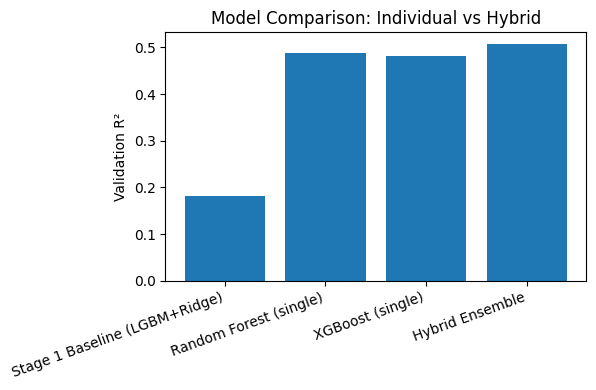

In [34]:
plt.figure(figsize=(6, 4))
plt.bar(comparison_df["Model"], comparison_df["Validation R2"])
plt.xticks(rotation=20, ha="right")
plt.ylabel("Validation R²")
plt.title("Model Comparison: Individual vs Hybrid")
plt.tight_layout()
plt.show()


## 8 Full Model Training, Test Preparation and Submission

After validating the two-stage hybrid model, the final steps are as follows:

1. Train the hybrid model on the full training dataset (df_main).
2. Prepare the test feature table (df_test) using the same feature engineering steps as training.
3. Generate predictions for the Kaggle test set.
4. Save the predictions into submission.csv in the required format.

This ensures that:
- All available training data is used for final model fitting.
- The test set uses the same features and encodings as the training data.
- The final submission is fully reproducible from this notebook.

In [35]:
# ====================================================
# 8.1 FULL MODEL TRAINING ON ALL AVAILABLE DATA 
# ====================================================
print("--- Training final hybrid model on all available data ---")

# Refit Stage 1 scaler on full data
full_s1_scaler = RobustScaler().fit(df_main[stage1_features])
X_full_s1_scaled = full_s1_scaler.transform(df_main[stage1_features])

# Refit Stage 1 models on FULL df_main
s1_lgbm.fit(df_main[stage1_features], df_main[target])
s1_ridge.fit(X_full_s1_scaled, df_main[target])

# Recompute Stage 1 predictions & residuals on full data
df_main['stage1_preds'] = (
    s1_lgbm.predict(df_main[stage1_features])
    + s1_ridge.predict(X_full_s1_scaled)
) / 2

df_main['residual'] = df_main[target] - df_main['stage1_preds']

# Refit Stage 2 models on FULL residuals (no early stopping now)
s2_rf.fit(df_main[stage2_features], df_main['residual'])
s2_xgb.set_params(early_stopping_rounds=None).fit(df_main[stage2_features], df_main['residual'])

print("Final hybrid model trained.")


--- Training final hybrid model on all available data ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 676
[LightGBM] [Info] Number of data points in the train set: 214046, number of used features: 11
[LightGBM] [Info] Start training from score 41.616568
Final hybrid model trained.


In [36]:
# =====================================
# 8.2 TEST SET PREPARATION 
# =====================================
print("--- Preparing Test Set ---")

df_test = sample_submission.copy()
df_test['book_theater_id'] = df_test['ID'].str.extract(r'(book_\d+)_')
df_test['show_date'] = pd.to_datetime(
    df_test['ID'].str.extract(r'_(\d{4}-\d{2}-\d{2})$')[0]
)

# Merge date + theater + geo features (same as df_main pipeline)
df_test = df_test.merge(date_info, on='show_date', how='left')
df_test = df_test.merge(
    booknow_theaters.drop(columns=['latitude', 'longitude']),
    on='book_theater_id',
    how='left'
)
df_test = df_test.merge(theater_geo_features, on='book_theater_id', how='left')

df_test['theater_type'].fillna('Unknown', inplace=True)
df_test['theater_area'].fillna('Unknown', inplace=True)

# Calendar features
df_test['show_month'] = df_test['show_date'].dt.month
df_test['show_quarter'] = df_test['show_date'].dt.quarter
df_test['show_dayofyear'] = df_test['show_date'].dt.dayofyear
df_test['show_weekofyear'] = df_test['show_date'].dt.isocalendar().week.astype('int32')
df_test['show_dayofweek_num'] = df_test['show_date'].dt.dayofweek
df_test['is_weekend'] = (df_test['show_dayofweek_num'] >= 5).astype(int)
df_test['is_friday'] = (df_test['show_dayofweek_num'] == 4).astype(int)

# Market + daily booking aggregates
df_test = df_test.merge(market_trends, on='show_date', how='left')

df_test = df_test.merge(
    daily_bn.rename(columns={
        'tickets': 'tickets_online',
        'mean_lead': 'mean_lead_online',
        'num_shows': 'num_shows_online',
        'frac_evening': 'frac_evening_online'
    }),
    on=['show_date', 'book_theater_id'],
    how='left'
)

df_test = df_test.merge(
    daily_cp.rename(columns={
        'tickets': 'tickets_pos',
        'mean_lead': 'mean_lead_pos',
        'num_shows': 'num_shows_pos',
        'frac_evening': 'frac_evening_pos'
    }),
    on=['show_date', 'book_theater_id'],
    how='left'
)

# Fill booking-related NaNs
for col in [
    'tickets_online', 'tickets_pos',
    'num_shows_online', 'num_shows_pos',
    'frac_evening_online', 'frac_evening_pos'
]:
    df_test[col].fillna(0, inplace=True)

for col in ['mean_lead_online', 'mean_lead_pos']:
    df_test[col].fillna(df_main[col].median(), inplace=True)

df_test['total_tickets'] = df_test['tickets_online'] + df_test['tickets_pos']
df_test['total_num_shows'] = df_test['num_shows_online'] + df_test['num_shows_pos']
df_test['online_ratio'] = df_test['tickets_online'] / (df_test['total_tickets'] + 1e-5)

# Last-known lag/rolling values per theater
df_test = df_test.merge(last_known_values, on='book_theater_id', how='left')

# Interaction features (test)
df_test['interaction_tickets_weekend'] = df_test['total_tickets'] * (df_test['is_weekend'] + 1)
df_test['interaction_lag7_tickets'] = df_test['lag_7'] * df_test['total_tickets']

# Fill remaining numeric NaNs before statistical merges
for col in df_test.columns:
    if df_test[col].isnull().any() and pd.api.types.is_numeric_dtype(df_test[col]):
        df_test[col].fillna(df_main[col].median(), inplace=True)

# Statistical theater-level features
df_test = df_test.merge(
    theater_weekday_avg,
    on=['book_theater_id', 'day_of_week'],
    how='left'
)
df_test = df_test.merge(theater_avg, on='book_theater_id', how='left')

df_test['weekday_avg'].fillna(df_test['theater_avg'], inplace=True)
df_test['weekday_avg'].fillna(global_avg, inplace=True)
df_test['theater_avg'].fillna(global_avg, inplace=True)

df_test = df_test.merge(last_rolling_7, on='book_theater_id', how='left')
df_test['last_rolling_7'].fillna(global_avg, inplace=True)

# Statistical baseline prediction
stat_predictions = 0.5 * df_test['weekday_avg'] + 0.5 * df_test['last_rolling_7']

# Encode categoricals in test using fitted encoders
for col in categorical_cols:
    le = encoders[col]
    df_test[col] = df_test[col].apply(
        lambda x: le.transform([str(x)])[0] if str(x) in le.classes_ else -1
    )

# Align test columns with df_main (any missing columns filled with 0)
df_test = df_test.reindex(columns=df_main.columns, fill_value=0)

print("Test set prepared.")
print("df_test shape:", df_test.shape)


--- Preparing Test Set ---
Test set prepared.
df_test shape: (38062, 41)


In [37]:
# ===================================================================
# 8.3 FINAL PREDICTION
# ===================================================================

# Stage 1 predictions on test (with scaling for Ridge)
X_test_s1_scaled = full_s1_scaler.transform(df_test[stage1_features])

s1_preds_test_lgbm = s1_lgbm.predict(df_test[stage1_features])
s1_preds_test_ridge = s1_ridge.predict(X_test_s1_scaled)

stage1_preds_test = (s1_preds_test_lgbm + s1_preds_test_ridge) / 2
df_test['stage1_preds'] = stage1_preds_test

# Stage 2 predictions on test (residuals)
s2_preds_test_rf = s2_rf.predict(df_test[stage2_features])
s2_preds_test_xgb = s2_xgb.predict(df_test[stage2_features])


stage2_preds_test = (s2_preds_test_rf * 0.6 + s2_preds_test_xgb * 0.4)

ml_predictions = stage1_preds_test + stage2_preds_test

# Blend ML and statistical predictions (0.3 ML, 0.7 statistical)
final_predictions = 0.3 * ml_predictions + 0.7 * stat_predictions

# Safety clipping and rounding
final_predictions = np.maximum(0, final_predictions)
final_predictions = np.round(final_predictions).astype(int)

print("Final test predictions generated.")

Final test predictions generated.


## Submission

In [38]:
# ===================================================================
# 8.4 SUBMISSION FILE GENERATION
# ===================================================================
submission_df = sample_submission[['ID']].copy()
submission_df['audience_count'] = final_predictions

submission_df.to_csv('submission.csv', index=False)

print("\n Submission file 'submission.csv' created successfully!")
print("--- Submission Head ---")
print(submission_df.head())

print("\n--- Test Prediction Distribution ---")
print(submission_df['audience_count'].describe())
gc.collect();


 Submission file 'submission.csv' created successfully!
--- Submission Head ---
                      ID  audience_count
0  book_00001_2024-03-01              39
1  book_00001_2024-03-02              51
2  book_00001_2024-03-03              48
3  book_00001_2024-03-04              30
4  book_00001_2024-03-06              36

--- Test Prediction Distribution ---
count    38062.000000
mean        42.362199
std         22.636896
min          2.000000
25%         24.000000
50%         38.000000
75%         57.000000
max        172.000000
Name: audience_count, dtype: float64
